# Sklearn Regression Models in py-tidymodels

This notebook demonstrates the comprehensive sklearn regression model integration in py-tidymodels, showcasing five powerful algorithms:

1. **decision_tree()** - Tree-based recursive partitioning
2. **nearest_neighbor()** - Instance-based learning
3. **svm_rbf()** - Support Vector Machines with RBF kernel
4. **svm_linear()** - Support Vector Machines with linear kernel
5. **mlp()** - Multi-layer Perceptron neural networks

Each model follows the tidymodels philosophy: specify → fit → predict.

In [34]:
!pip install -e.

Obtaining file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/examples
ERROR: file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/examples does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression, make_friedman1
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from py_parsnip import decision_tree, nearest_neighbor, svm_rbf, svm_linear, mlp

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)

## 1. Decision Tree Regression

Decision trees recursively partition the feature space using binary splits. They're interpretable and can capture non-linear patterns, but are prone to overfitting.

### Key Parameters:
- `tree_depth`: Maximum depth of the tree (controls complexity)
- `min_n`: Minimum samples required to split a node
- `cost_complexity`: Pruning parameter (alpha)

In [36]:
# Generate non-linear data
np.random.seed(42)
X_tree = np.sort(np.random.rand(200, 1) * 10, axis=0)
y_tree = np.sin(X_tree).ravel() + np.random.randn(200) * 0.3

X_train, X_test, y_train, y_test = train_test_split(X_tree, y_tree, test_size=0.3, random_state=42)

# Convert to DataFrames
train_df = pd.DataFrame({'X': X_train.ravel(), 'y': y_train})
test_df = pd.DataFrame({'X': X_test.ravel(), 'y': y_test})

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Training data shape: (140, 2)
Test data shape: (60, 2)


### Tree Depth Tuning

Let's compare different tree depths to understand the bias-variance tradeoff:

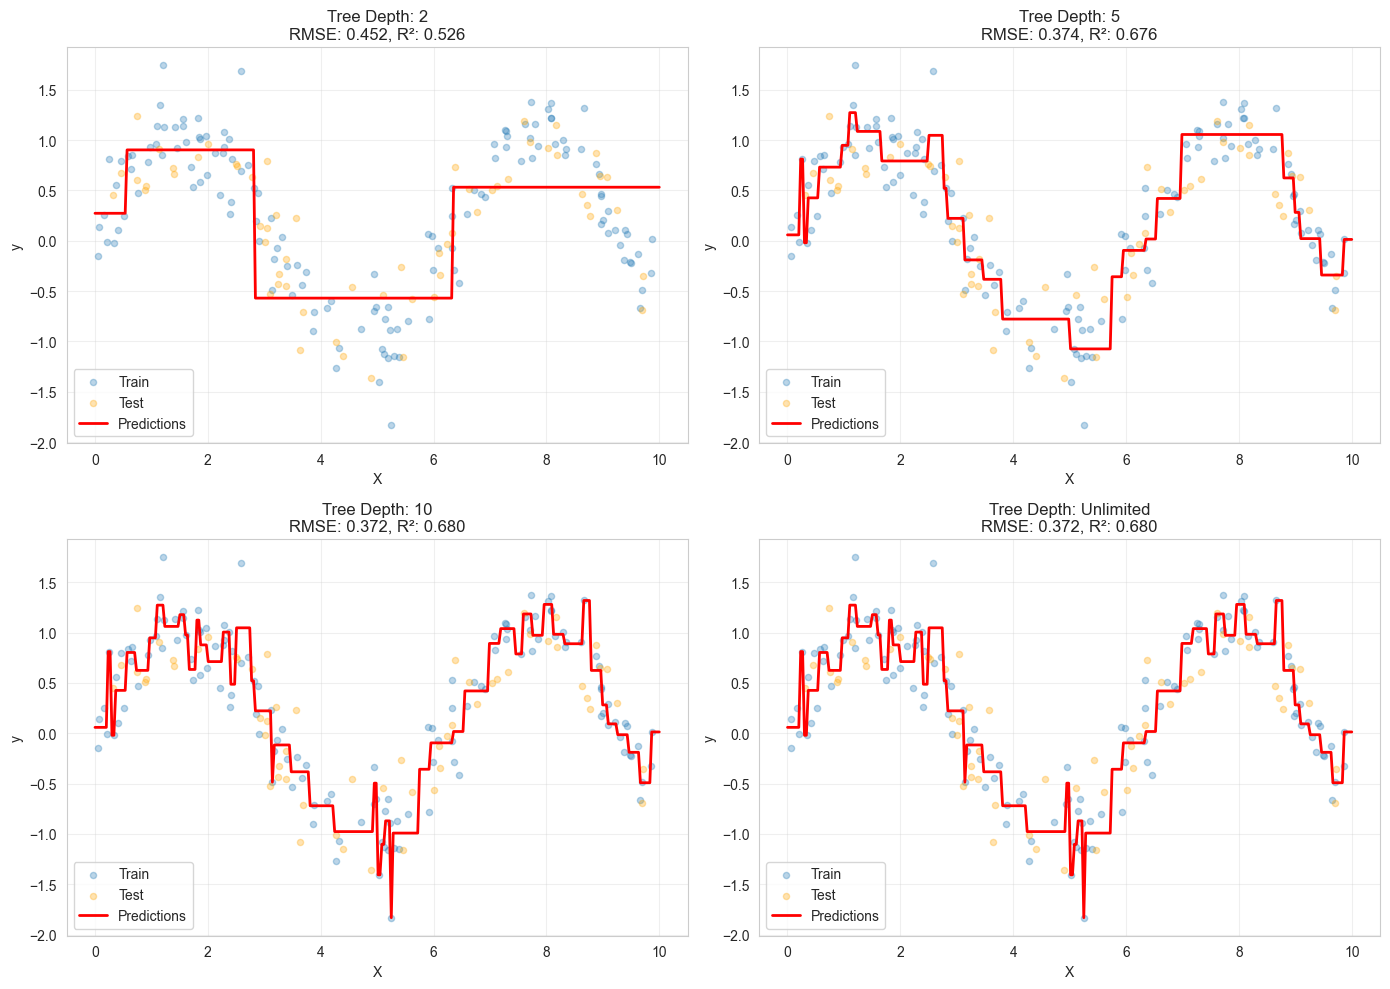


Observations:
- Shallow trees (depth=2): High bias, underfit the data
- Medium trees (depth=5): Good balance
- Deep trees (depth=10+): Low bias but high variance, overfit training data


In [37]:
# Compare different tree depths
depths = [2, 5, 10, None]  # None means unlimited depth
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

X_plot = np.linspace(0, 10, 300).reshape(-1, 1)
plot_df = pd.DataFrame({'X': X_plot.ravel()})

for idx, depth in enumerate(depths):
    # Specify and fit model
    model = decision_tree(tree_depth=depth, min_n=5).set_mode('regression')
    fitted = model.fit(train_df, 'y ~ X')
    
    # Predict
    predictions = fitted.predict(plot_df)
    test_preds = fitted.predict(test_df)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test_df['y'], test_preds['.pred']))
    r2 = r2_score(test_df['y'], test_preds['.pred'])
    
    # Plot
    ax = axes[idx]
    ax.scatter(train_df['X'], train_df['y'], alpha=0.3, label='Train', s=20)
    ax.scatter(test_df['X'], test_df['y'], alpha=0.3, label='Test', s=20, color='orange')
    ax.plot(X_plot, predictions['.pred'], 'r-', linewidth=2, label='Predictions')
    
    depth_label = 'Unlimited' if depth is None else depth
    ax.set_title(f'Tree Depth: {depth_label}\nRMSE: {rmse:.3f}, R²: {r2:.3f}')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Shallow trees (depth=2): High bias, underfit the data")
print("- Medium trees (depth=5): Good balance")
print("- Deep trees (depth=10+): Low bias but high variance, overfit training data")

### Feature Importance

Decision trees can tell us which features are most important for predictions:

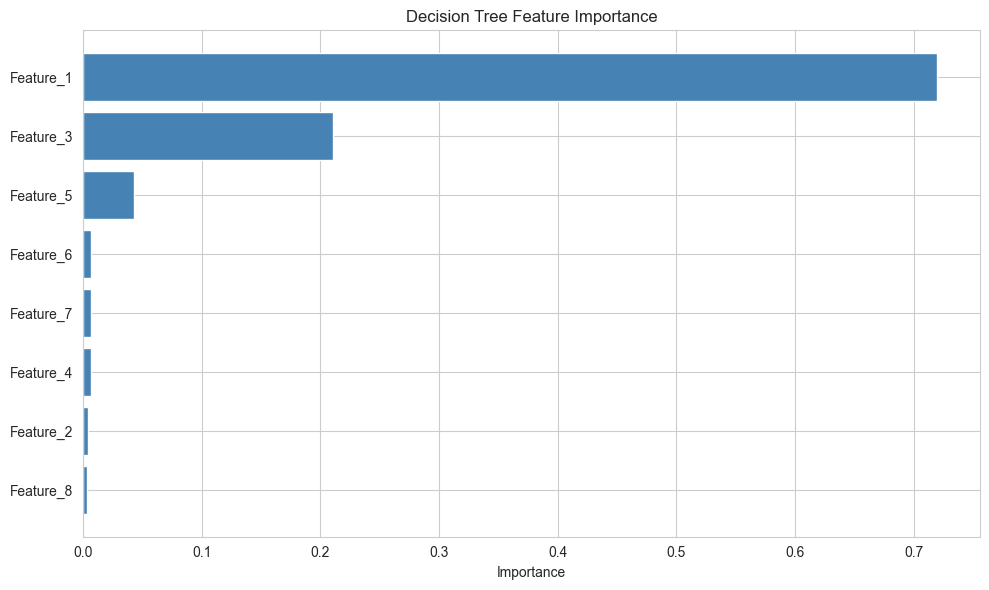


Feature Importance Rankings:
  Feature  Importance
Feature_1    0.719811
Feature_3    0.210492
Feature_5    0.042968
Feature_6    0.006657
Feature_7    0.006622
Feature_4    0.006612
Feature_2    0.003904
Feature_8    0.002934


In [38]:
# Create multi-feature dataset
X_multi, y_multi = make_regression(
    n_samples=300, 
    n_features=8, 
    n_informative=5,
    noise=20,
    random_state=42
)

feature_names = [f'Feature_{i+1}' for i in range(8)]
df_multi = pd.DataFrame(X_multi, columns=feature_names)
df_multi['target'] = y_multi

# Fit decision tree
model = decision_tree(tree_depth=8, min_n=10).set_mode('regression')
fitted = model.fit(df_multi, 'target ~ .')

# Extract feature importance
importance = fitted.fit_data["model"].feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Decision Tree Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nFeature Importance Rankings:")
print(importance_df.to_string(index=False))

### Overfitting Example

Let's demonstrate how overfitting manifests with unlimited tree depth:

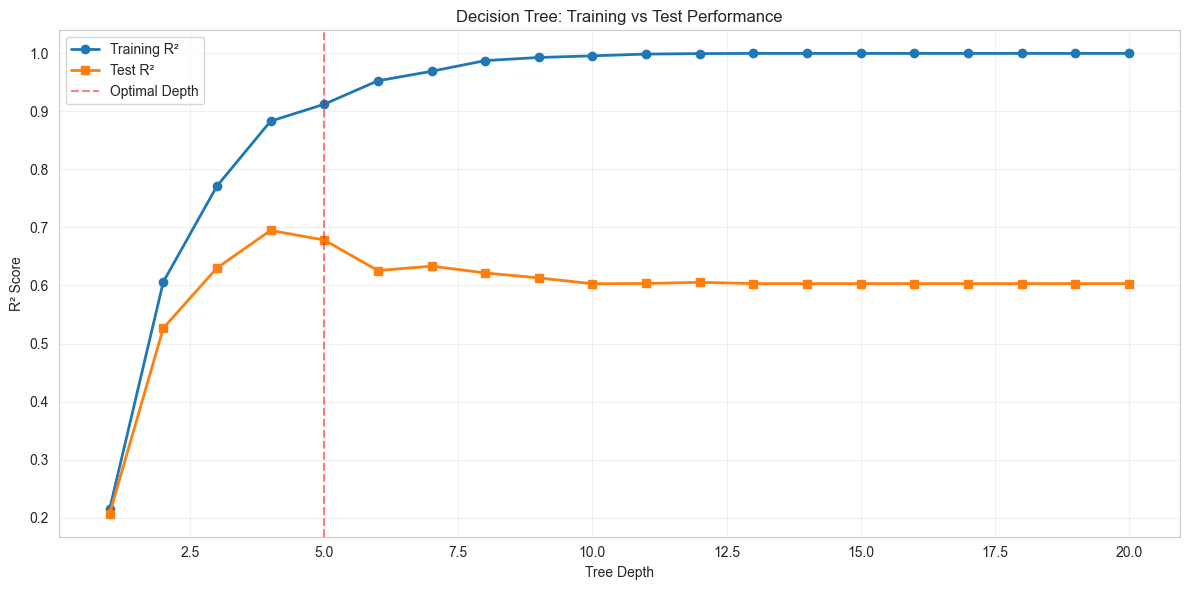


Key Insight:
The gap between training and test scores indicates overfitting.
Optimal depth appears to be around 4.


In [39]:
# Train models with different complexities
depths_range = range(1, 21)
train_scores = []
test_scores = []

for depth in depths_range:
    model = decision_tree(tree_depth=depth, min_n=2).set_mode('regression')
    fitted = model.fit(train_df, 'y ~ X')
    
    train_pred = fitted.predict(train_df)
    test_pred = fitted.predict(test_df)
    
    train_scores.append(r2_score(train_df['y'], train_pred['.pred']))
    test_scores.append(r2_score(test_df['y'], test_pred['.pred']))

# Plot learning curves
plt.figure(figsize=(12, 6))
plt.plot(depths_range, train_scores, 'o-', label='Training R²', linewidth=2)
plt.plot(depths_range, test_scores, 's-', label='Test R²', linewidth=2)
plt.axvline(x=5, color='red', linestyle='--', alpha=0.5, label='Optimal Depth')
plt.xlabel('Tree Depth')
plt.ylabel('R² Score')
plt.title('Decision Tree: Training vs Test Performance')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("The gap between training and test scores indicates overfitting.")
print(f"Optimal depth appears to be around {depths_range[np.argmax(test_scores)]}.")

## 2. Nearest Neighbor Regression (k-NN)

k-NN is a non-parametric method that predicts based on the k closest training examples.

### Key Parameters:
- `neighbors`: Number of neighbors to consider
- `dist_power`: Distance metric power (1=Manhattan, 2=Euclidean)
- `weight_func`: How to weight neighbors ('uniform' or 'distance')

In [40]:
# Generate smooth non-linear data
np.random.seed(42)
X_knn = np.sort(np.random.rand(150, 1) * 10, axis=0)
y_knn = 2 * np.sin(X_knn).ravel() + 0.5 * X_knn.ravel() + np.random.randn(150) * 0.5

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_knn, y_knn, test_size=0.3, random_state=42
)

train_knn = pd.DataFrame({'X': X_train_knn.ravel(), 'y': y_train_knn})
test_knn = pd.DataFrame({'X': X_test_knn.ravel(), 'y': y_test_knn})

print("k-NN dataset created with 150 samples")

k-NN dataset created with 150 samples


### k Selection

The number of neighbors is crucial - too few leads to overfitting, too many leads to undersmoothing:

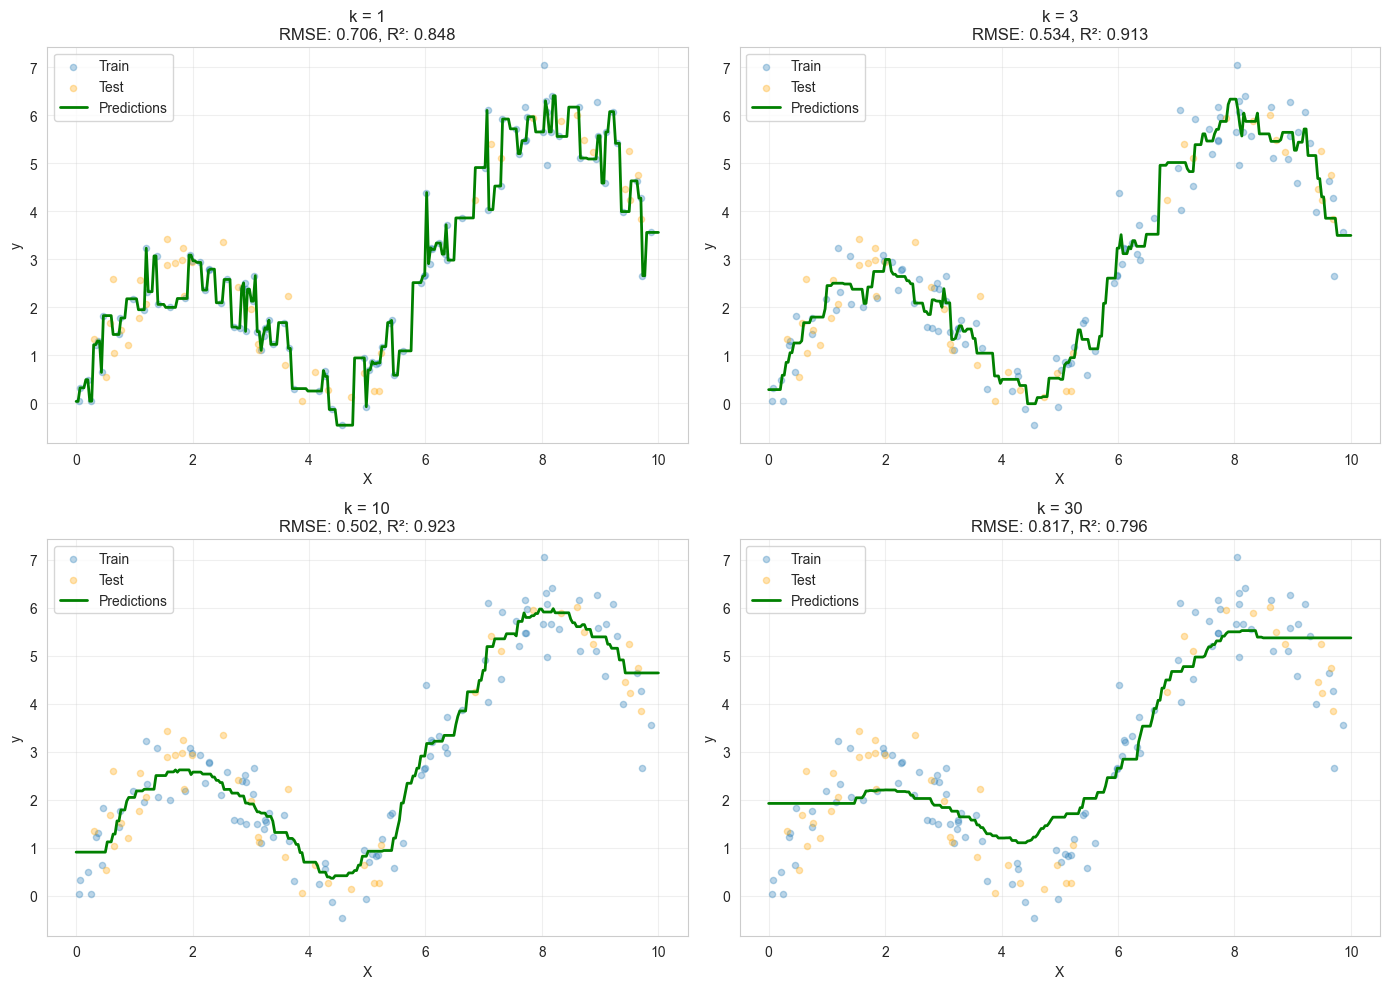


Observations:
- k=1: Very jagged, overfits to training noise
- k=3-10: Smooth predictions, captures underlying pattern
- k=30: Over-smoothed, misses local variations


In [41]:
# Compare different k values
k_values = [1, 3, 10, 30]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

X_plot = np.linspace(0, 10, 300).reshape(-1, 1)
plot_knn = pd.DataFrame({'X': X_plot.ravel()})

for idx, k in enumerate(k_values):
    # Specify and fit model
    model = nearest_neighbor(neighbors=k).set_mode('regression')
    fitted = model.fit(train_knn, 'y ~ X')
    
    # Predict
    predictions = fitted.predict(plot_knn)
    test_preds = fitted.predict(test_knn)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test_knn['y'], test_preds['.pred']))
    r2 = r2_score(test_knn['y'], test_preds['.pred'])
    
    # Plot
    ax = axes[idx]
    ax.scatter(train_knn['X'], train_knn['y'], alpha=0.3, label='Train', s=20)
    ax.scatter(test_knn['X'], test_knn['y'], alpha=0.3, label='Test', s=20, color='orange')
    ax.plot(X_plot, predictions['.pred'], 'g-', linewidth=2, label='Predictions')
    
    ax.set_title(f'k = {k}\nRMSE: {rmse:.3f}, R²: {r2:.3f}')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- k=1: Very jagged, overfits to training noise")
print("- k=3-10: Smooth predictions, captures underlying pattern")
print("- k=30: Over-smoothed, misses local variations")

### Distance Metrics

The `dist_power` parameter controls the distance metric:
- `dist_power=1`: Manhattan distance (L1)
- `dist_power=2`: Euclidean distance (L2)

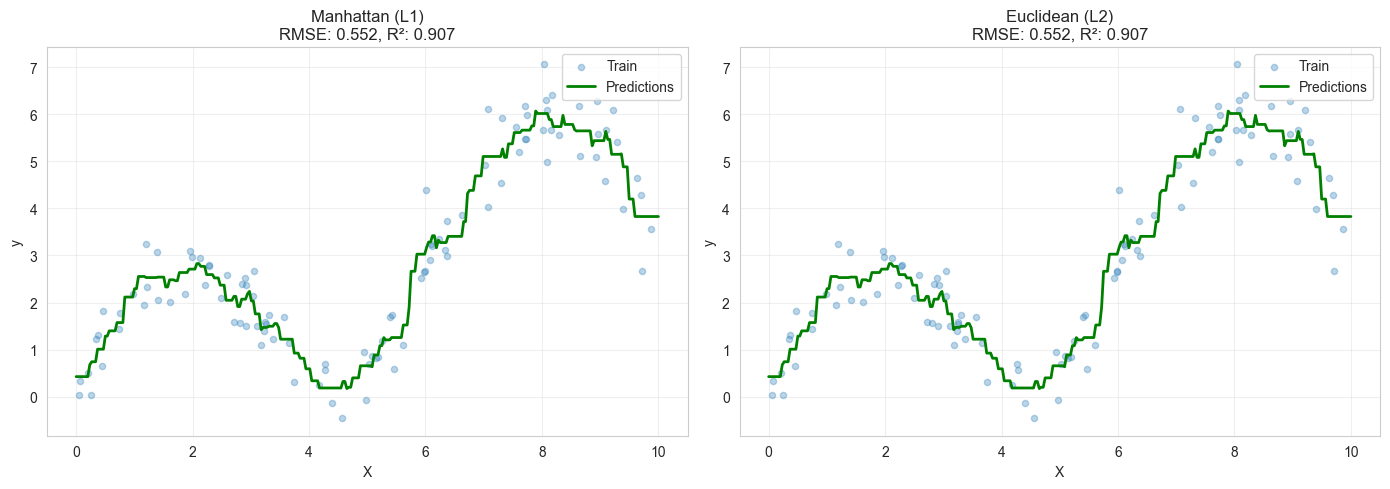


In 1D, Manhattan and Euclidean distances give similar results.
Differences become more pronounced in higher dimensions.


In [42]:
# Compare distance metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (power, name) in enumerate([(1, 'Manhattan (L1)'), (2, 'Euclidean (L2)')]):
    model = nearest_neighbor(neighbors=5, dist_power=power).set_mode('regression')
    fitted = model.fit(train_knn, 'y ~ X')
    
    predictions = fitted.predict(plot_knn)
    test_preds = fitted.predict(test_knn)
    
    rmse = np.sqrt(mean_squared_error(test_knn['y'], test_preds['.pred']))
    r2 = r2_score(test_knn['y'], test_preds['.pred'])
    
    ax = axes[idx]
    ax.scatter(train_knn['X'], train_knn['y'], alpha=0.3, label='Train', s=20)
    ax.plot(X_plot, predictions['.pred'], 'g-', linewidth=2, label='Predictions')
    ax.set_title(f'{name}\nRMSE: {rmse:.3f}, R²: {r2:.3f}')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nIn 1D, Manhattan and Euclidean distances give similar results.")
print("Differences become more pronounced in higher dimensions.")

### Weighting Functions

Weighting determines how much influence each neighbor has:
- `uniform`: All neighbors weighted equally
- `distance`: Closer neighbors have more influence

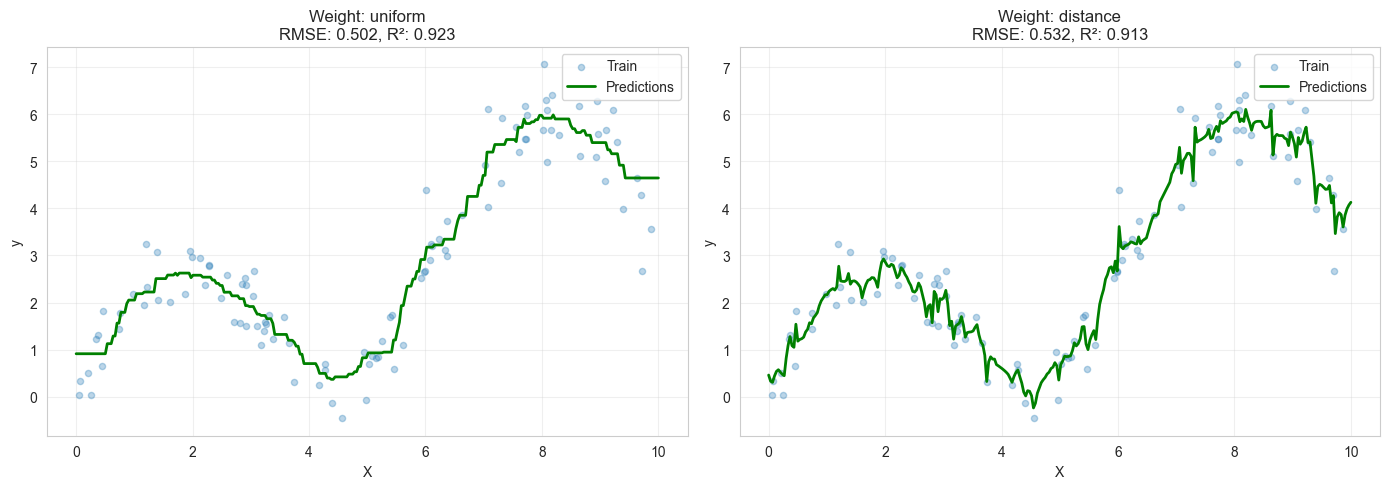


Distance weighting generally provides smoother predictions.
Closer neighbors have more influence, making the model more adaptive.


In [43]:
# Compare weighting functions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, weight in enumerate(['uniform', 'distance']):
    model = nearest_neighbor(neighbors=10, weight_func=weight).set_mode('regression')
    fitted = model.fit(train_knn, 'y ~ X')
    
    predictions = fitted.predict(plot_knn)
    test_preds = fitted.predict(test_knn)
    
    rmse = np.sqrt(mean_squared_error(test_knn['y'], test_preds['.pred']))
    r2 = r2_score(test_knn['y'], test_preds['.pred'])
    
    ax = axes[idx]
    ax.scatter(train_knn['X'], train_knn['y'], alpha=0.3, label='Train', s=20)
    ax.plot(X_plot, predictions['.pred'], 'g-', linewidth=2, label='Predictions')
    ax.set_title(f'Weight: {weight}\nRMSE: {rmse:.3f}, R²: {r2:.3f}')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDistance weighting generally provides smoother predictions.")
print("Closer neighbors have more influence, making the model more adaptive.")

## 3. Support Vector Machine with RBF Kernel

SVM with RBF (Radial Basis Function) kernel can model complex non-linear relationships by implicitly mapping data to high-dimensional space.

### Key Parameters:
- `cost`: Penalty for misclassification (C parameter)
- `rbf_sigma`: Kernel coefficient (gamma), controls smoothness

In [44]:
# Generate complex non-linear data
np.random.seed(42)
X_svm = np.sort(np.random.rand(200, 1) * 10, axis=0)
y_svm = (np.sin(X_svm) * X_svm).ravel() + np.random.randn(200) * 1.5

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_svm, y_svm, test_size=0.3, random_state=42
)

train_svm = pd.DataFrame({'X': X_train_svm.ravel(), 'y': y_train_svm})
test_svm = pd.DataFrame({'X': X_test_svm.ravel(), 'y': y_test_svm})

print("SVM dataset created with complex non-linear pattern")

SVM dataset created with complex non-linear pattern


### Cost and Sigma Tuning

These parameters control the bias-variance tradeoff:
- **cost**: Higher values fit training data more closely (risk overfitting)
- **rbf_sigma**: Higher values create more flexible decision boundaries

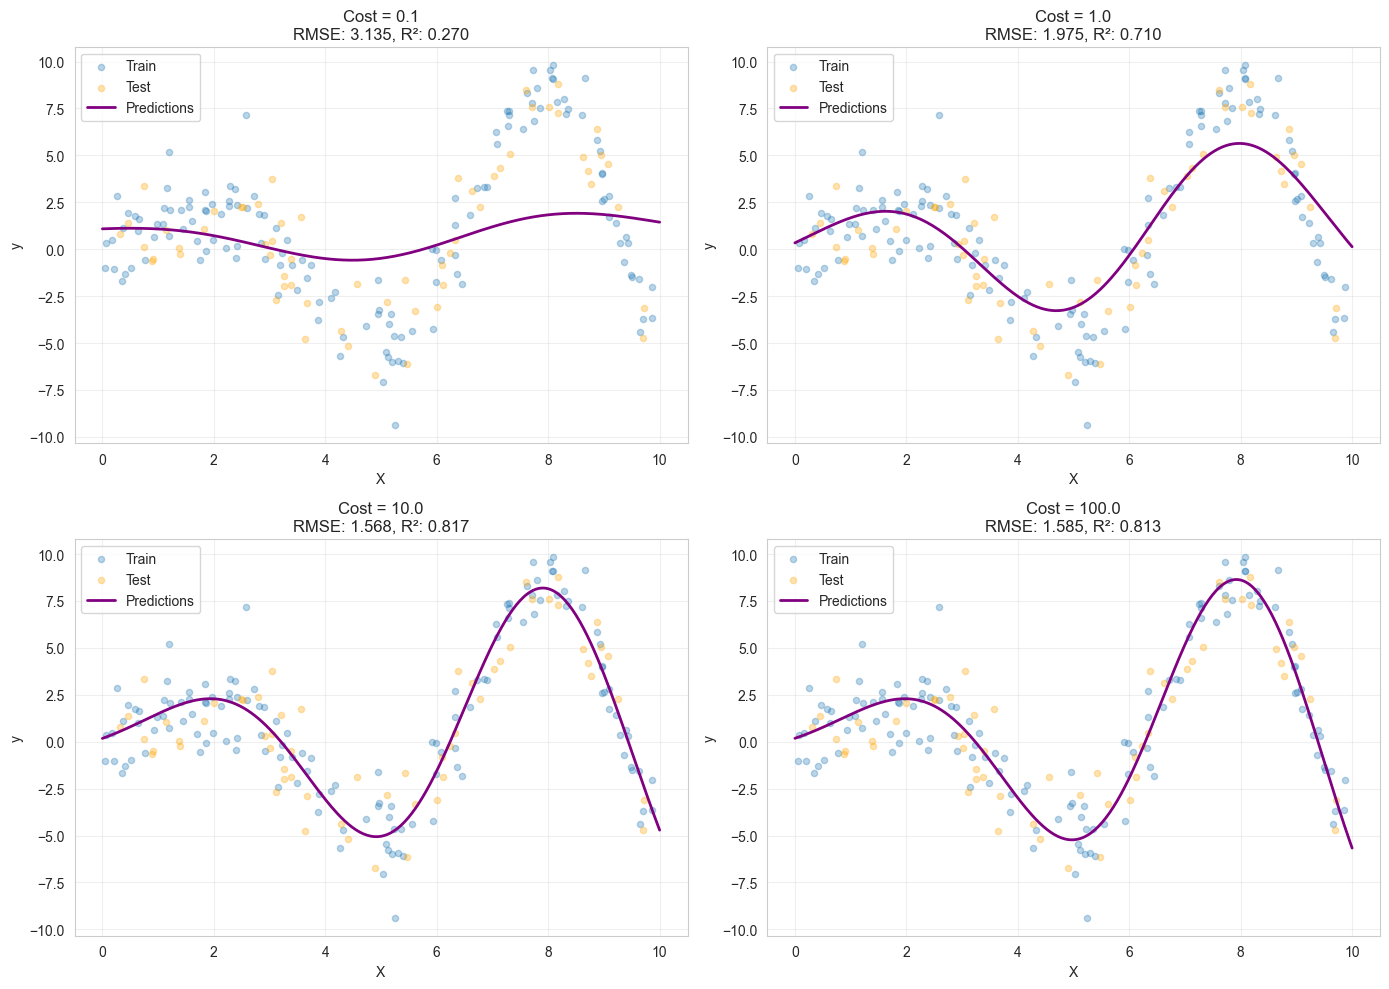


Cost parameter effects:
- Low cost (0.1): More regularization, smoother fit
- High cost (100): Less regularization, fits training data more closely


In [45]:
# Compare different cost values
cost_values = [0.1, 1.0, 10.0, 100.0]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

X_plot = np.linspace(0, 10, 300).reshape(-1, 1)
plot_svm = pd.DataFrame({'X': X_plot.ravel()})

for idx, cost in enumerate(cost_values):
    # Specify and fit model (using default rbf_sigma)
    model = svm_rbf(cost=cost).set_mode('regression')
    fitted = model.fit(train_svm, 'y ~ X')
    
    # Predict
    predictions = fitted.predict(plot_svm)
    test_preds = fitted.predict(test_svm)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test_svm['y'], test_preds['.pred']))
    r2 = r2_score(test_svm['y'], test_preds['.pred'])
    
    # Plot
    ax = axes[idx]
    ax.scatter(train_svm['X'], train_svm['y'], alpha=0.3, label='Train', s=20)
    ax.scatter(test_svm['X'], test_svm['y'], alpha=0.3, label='Test', s=20, color='orange')
    ax.plot(X_plot, predictions['.pred'], 'purple', linewidth=2, label='Predictions')
    
    ax.set_title(f'Cost = {cost}\nRMSE: {rmse:.3f}, R²: {r2:.3f}')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCost parameter effects:")
print("- Low cost (0.1): More regularization, smoother fit")
print("- High cost (100): Less regularization, fits training data more closely")

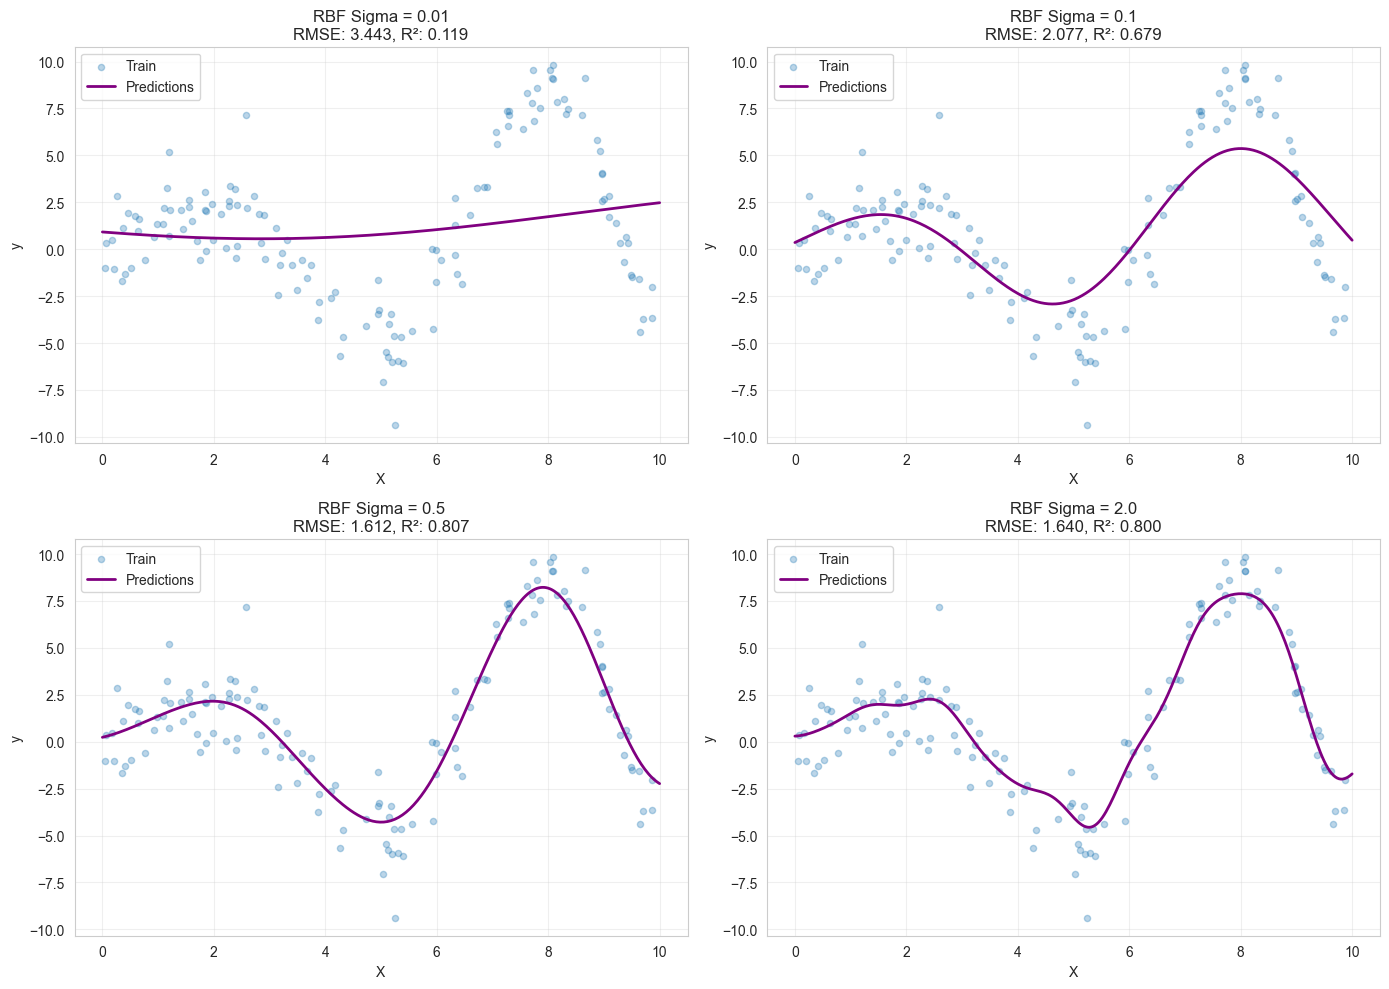


RBF Sigma effects:
- Low sigma (0.01): Wide influence, smoother predictions
- High sigma (2.0): Narrow influence, more local fitting


In [46]:
# Compare different sigma values
sigma_values = [0.01, 0.1, 0.5, 2.0]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, sigma in enumerate(sigma_values):
    # Specify and fit model
    model = svm_rbf(cost=1.0, rbf_sigma=sigma).set_mode('regression')
    fitted = model.fit(train_svm, 'y ~ X')
    
    # Predict
    predictions = fitted.predict(plot_svm)
    test_preds = fitted.predict(test_svm)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test_svm['y'], test_preds['.pred']))
    r2 = r2_score(test_svm['y'], test_preds['.pred'])
    
    # Plot
    ax = axes[idx]
    ax.scatter(train_svm['X'], train_svm['y'], alpha=0.3, label='Train', s=20)
    ax.plot(X_plot, predictions['.pred'], 'purple', linewidth=2, label='Predictions')
    
    ax.set_title(f'RBF Sigma = {sigma}\nRMSE: {rmse:.3f}, R²: {r2:.3f}')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRBF Sigma effects:")
print("- Low sigma (0.01): Wide influence, smoother predictions")
print("- High sigma (2.0): Narrow influence, more local fitting")

### Non-linear Pattern Modeling

SVM-RBF excels at capturing complex non-linear relationships:

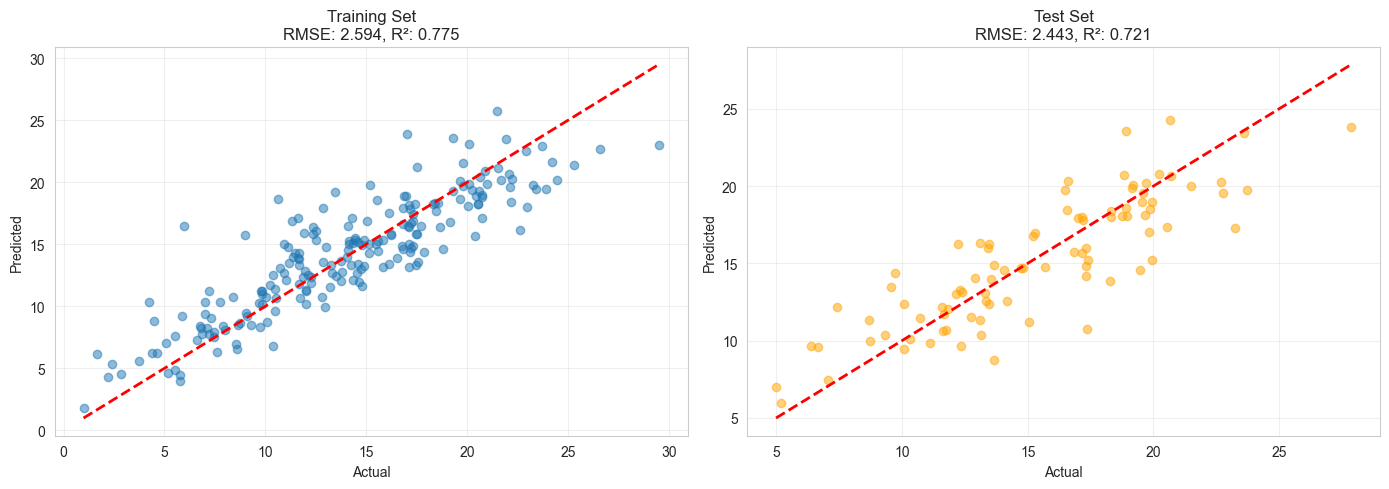


SVM-RBF effectively captures complex non-linear relationships.
Test R² of 0.721 demonstrates strong generalization.


In [47]:
# Create dataset with multiple non-linear patterns
X_complex, y_complex = make_friedman1(n_samples=300, n_features=5, noise=1.0, random_state=42)
df_complex = pd.DataFrame(X_complex, columns=[f'X{i+1}' for i in range(5)])
df_complex['y'] = y_complex

train_complex, test_complex = train_test_split(df_complex, test_size=0.3, random_state=42)

# Fit SVM-RBF
model_rbf = svm_rbf(cost=10.0, rbf_sigma=0.1).set_mode('regression')
fitted_rbf = model_rbf.fit(train_complex, 'y ~ .')

# Predict
train_pred = fitted_rbf.predict(train_complex)
test_pred = fitted_rbf.predict(test_complex)

# Evaluate
train_rmse = np.sqrt(mean_squared_error(train_complex['y'], train_pred['.pred']))
test_rmse = np.sqrt(mean_squared_error(test_complex['y'], test_pred['.pred']))
train_r2 = r2_score(train_complex['y'], train_pred['.pred'])
test_r2 = r2_score(test_complex['y'], test_pred['.pred'])

# Plot predictions vs actuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training
axes[0].scatter(train_complex['y'], train_pred['.pred'], alpha=0.5)
axes[0].plot([train_complex['y'].min(), train_complex['y'].max()], 
             [train_complex['y'].min(), train_complex['y'].max()], 
             'r--', linewidth=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title(f'Training Set\nRMSE: {train_rmse:.3f}, R²: {train_r2:.3f}')
axes[0].grid(alpha=0.3)

# Test
axes[1].scatter(test_complex['y'], test_pred['.pred'], alpha=0.5, color='orange')
axes[1].plot([test_complex['y'].min(), test_complex['y'].max()], 
             [test_complex['y'].min(), test_complex['y'].max()], 
             'r--', linewidth=2)
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title(f'Test Set\nRMSE: {test_rmse:.3f}, R²: {test_r2:.3f}')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSVM-RBF effectively captures complex non-linear relationships.")
print(f"Test R² of {test_r2:.3f} demonstrates strong generalization.")

### Kernel Visualization Concept

The RBF kernel implicitly maps data to infinite-dimensional space. We can visualize the effect on a 2D problem:

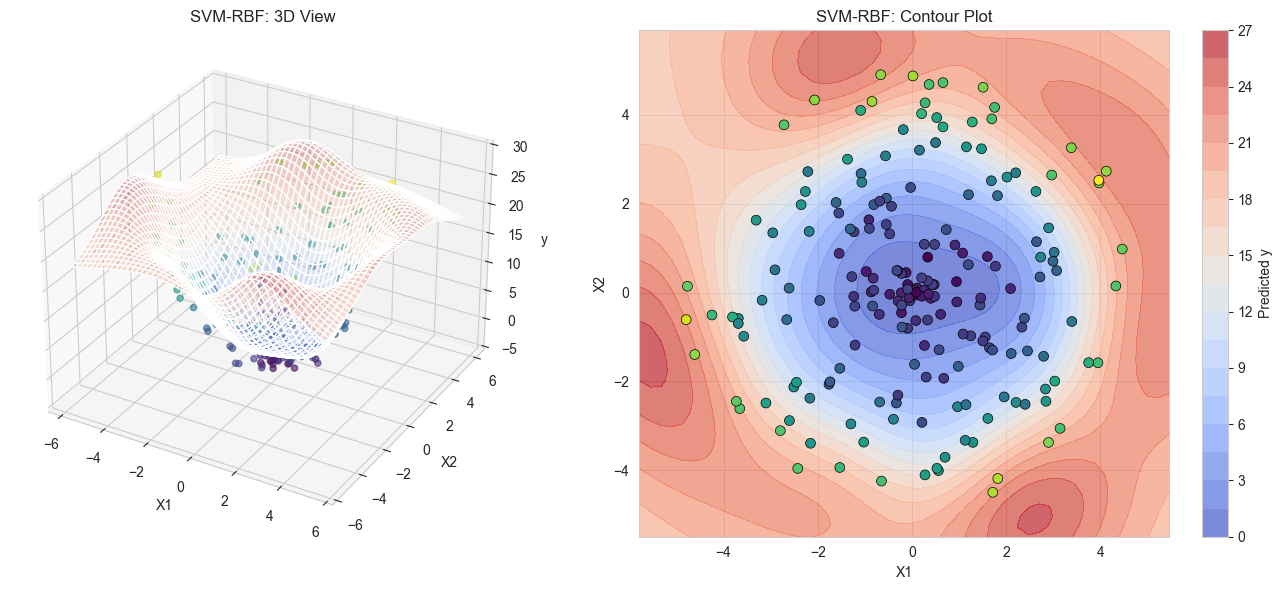


The RBF kernel creates smooth, non-linear decision surfaces.
It effectively handles circular/radial patterns in the data.


In [48]:
# Create 2D circular pattern
np.random.seed(42)
n_samples = 200
theta = np.random.rand(n_samples) * 2 * np.pi
r = np.random.rand(n_samples) * 5

X_circle = np.column_stack([r * np.cos(theta), r * np.sin(theta)])
y_circle = r**2 + np.random.randn(n_samples) * 2

df_circle = pd.DataFrame(X_circle, columns=['X1', 'X2'])
df_circle['y'] = y_circle

# Fit SVM-RBF
model_circle = svm_rbf(cost=10.0, rbf_sigma=0.2).set_mode('regression')
fitted_circle = model_circle.fit(df_circle, 'y ~ X1 + X2')

# Create prediction grid
x1_range = np.linspace(X_circle[:, 0].min() - 1, X_circle[:, 0].max() + 1, 50)
x2_range = np.linspace(X_circle[:, 1].min() - 1, X_circle[:, 1].max() + 1, 50)
X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)
grid_df = pd.DataFrame({
    'X1': X1_grid.ravel(),
    'X2': X2_grid.ravel()
})

# Predict on grid
grid_pred = fitted_circle.predict(grid_df)
Z = grid_pred['.pred'].values.reshape(X1_grid.shape)

# Visualize
fig = plt.figure(figsize=(14, 6))

# 3D surface
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_circle[:, 0], X_circle[:, 1], y_circle, c=y_circle, cmap='viridis', alpha=0.6)
ax1.plot_surface(X1_grid, X2_grid, Z, alpha=0.3, cmap='coolwarm')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('y')
ax1.set_title('SVM-RBF: 3D View')

# Contour plot
ax2 = fig.add_subplot(122)
contour = ax2.contourf(X1_grid, X2_grid, Z, levels=20, cmap='coolwarm', alpha=0.7)
scatter = ax2.scatter(X_circle[:, 0], X_circle[:, 1], c=y_circle, cmap='viridis', 
                     edgecolor='black', linewidth=0.5, s=50)
plt.colorbar(contour, ax=ax2, label='Predicted y')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_title('SVM-RBF: Contour Plot')

plt.tight_layout()
plt.show()

print("\nThe RBF kernel creates smooth, non-linear decision surfaces.")
print("It effectively handles circular/radial patterns in the data.")

## 4. Support Vector Machine with Linear Kernel

SVM with linear kernel is efficient for high-dimensional data and when the relationship is approximately linear.

### Key Parameters:
- `cost`: Penalty for misclassification (C parameter)
- `margin`: Epsilon in epsilon-SVR (width of the tube)

In [49]:
# Generate high-dimensional linear data
X_linear, y_linear = make_regression(
    n_samples=200,
    n_features=50,  # High dimensional
    n_informative=30,
    noise=10,
    random_state=42
)

df_linear = pd.DataFrame(X_linear, columns=[f'X{i+1}' for i in range(50)])
df_linear['y'] = y_linear

train_linear, test_linear = train_test_split(df_linear, test_size=0.3, random_state=42)

print(f"High-dimensional dataset: {X_linear.shape[1]} features")
print(f"Training samples: {len(train_linear)}")
print(f"Test samples: {len(test_linear)}")

High-dimensional dataset: 50 features
Training samples: 140
Test samples: 60


### High-dimensional Data Performance

Linear SVM is computationally efficient in high dimensions:

In [50]:
import time

# Compare different cost values
cost_values = [0.1, 1.0, 10.0, 100.0]
results = []

for cost in cost_values:
    # Time the fitting
    start = time.time()
    model = svm_linear(cost=cost).set_mode('regression')
    fitted = model.fit(train_linear, 'y ~ .')
    fit_time = time.time() - start
    
    # Predict
    train_pred = fitted.predict(train_linear)
    test_pred = fitted.predict(test_linear)
    
    # Metrics
    train_rmse = np.sqrt(mean_squared_error(train_linear['y'], train_pred['.pred']))
    test_rmse = np.sqrt(mean_squared_error(test_linear['y'], test_pred['.pred']))
    train_r2 = r2_score(train_linear['y'], train_pred['.pred'])
    test_r2 = r2_score(test_linear['y'], test_pred['.pred'])
    
    results.append({
        'Cost': cost,
        'Fit Time (s)': f'{fit_time:.4f}',
        'Train RMSE': f'{train_rmse:.3f}',
        'Test RMSE': f'{test_rmse:.3f}',
        'Train R²': f'{train_r2:.3f}',
        'Test R²': f'{test_r2:.3f}'
    })

results_df = pd.DataFrame(results)
print("\nLinear SVM Performance on High-Dimensional Data:")
print(results_df.to_string(index=False))
print("\nNote: Linear SVM trains quickly even with 50 features!")


Linear SVM Performance on High-Dimensional Data:
 Cost Fit Time (s) Train RMSE Test RMSE Train R² Test R²
  0.1       0.0295    283.579   299.557    0.093   0.065
  1.0       0.0222    177.033   216.291    0.647   0.512
 10.0       0.0259     10.170    15.717    0.999   0.997
100.0       0.0289      9.472    13.270    0.999   0.998

Note: Linear SVM trains quickly even with 50 features!


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Comparison to SVM-RBF

Let's compare linear and RBF kernels on the same dataset:

In [51]:
# Create dataset with moderate non-linearity
X_comp, y_comp = make_friedman1(n_samples=300, n_features=10, noise=1.0, random_state=42)
df_comp = pd.DataFrame(X_comp, columns=[f'X{i+1}' for i in range(10)])
df_comp['y'] = y_comp

train_comp, test_comp = train_test_split(df_comp, test_size=0.3, random_state=42)

# Fit both models
models = {
    'Linear SVM': svm_linear(cost=1.0).set_mode('regression'),
    'RBF SVM': svm_rbf(cost=1.0, rbf_sigma=0.1).set_mode('regression')
}

comparison_results = []

for name, model in models.items():
    # Fit and predict
    start = time.time()
    fitted = model.fit(train_comp, 'y ~ .')
    fit_time = time.time() - start
    
    train_pred = fitted.predict(train_comp)
    test_pred = fitted.predict(test_comp)
    
    # Metrics
    train_r2 = r2_score(train_comp['y'], train_pred['.pred'])
    test_r2 = r2_score(test_comp['y'], test_pred['.pred'])
    test_rmse = np.sqrt(mean_squared_error(test_comp['y'], test_pred['.pred']))
    
    comparison_results.append({
        'Model': name,
        'Fit Time (s)': f'{fit_time:.4f}',
        'Train R²': f'{train_r2:.3f}',
        'Test R²': f'{test_r2:.3f}',
        'Test RMSE': f'{test_rmse:.3f}'
    })

comparison_df = pd.DataFrame(comparison_results)
print("\nLinear vs RBF Kernel Comparison:")
print(comparison_df.to_string(index=False))

print("\nKey Insights:")
print("- Linear SVM: Faster training, good for approximately linear relationships")
print("- RBF SVM: Better for non-linear patterns, but slower to train")
print("- Choice depends on data complexity and computational budget")


Linear vs RBF Kernel Comparison:
     Model Fit Time (s) Train R² Test R² Test RMSE
Linear SVM       0.0089    0.736   0.676     2.766
   RBF SVM       0.0079    0.515   0.480     3.505

Key Insights:
- Linear SVM: Faster training, good for approximately linear relationships
- RBF SVM: Better for non-linear patterns, but slower to train
- Choice depends on data complexity and computational budget


### Linear SVM on Simple Data

Visualize linear SVM on 1D data:

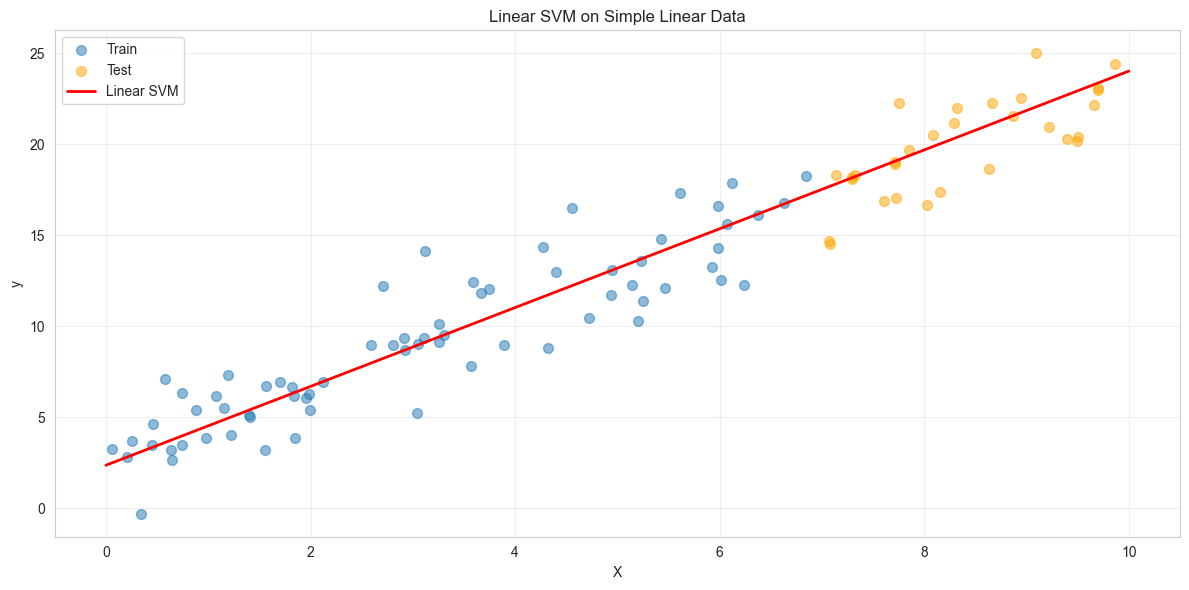


Test R²: 0.525
Linear SVM works well when the underlying relationship is approximately linear.


In [52]:
# Generate simple linear data with noise
np.random.seed(42)
X_simple = np.sort(np.random.rand(100, 1) * 10, axis=0)
y_simple = 2 * X_simple.ravel() + 3 + np.random.randn(100) * 2

train_simple = pd.DataFrame({'X': X_simple[:70].ravel(), 'y': y_simple[:70]})
test_simple = pd.DataFrame({'X': X_simple[70:].ravel(), 'y': y_simple[70:]})

# Fit linear SVM
model_simple = svm_linear(cost=1.0).set_mode('regression')
fitted_simple = model_simple.fit(train_simple, 'y ~ X')

# Predict
X_plot = np.linspace(0, 10, 300).reshape(-1, 1)
plot_simple = pd.DataFrame({'X': X_plot.ravel()})
predictions_simple = fitted_simple.predict(plot_simple)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(train_simple['X'], train_simple['y'], alpha=0.5, label='Train', s=50)
plt.scatter(test_simple['X'], test_simple['y'], alpha=0.5, label='Test', s=50, color='orange')
plt.plot(X_plot, predictions_simple['.pred'], 'r-', linewidth=2, label='Linear SVM')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear SVM on Simple Linear Data')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

test_pred_simple = fitted_simple.predict(test_simple)
test_r2 = r2_score(test_simple['y'], test_pred_simple['.pred'])
print(f"\nTest R²: {test_r2:.3f}")
print("Linear SVM works well when the underlying relationship is approximately linear.")

## 5. Multi-layer Perceptron (MLP)

MLPs are feedforward neural networks that can model complex non-linear relationships through multiple hidden layers.

### Key Parameters:
- `hidden_units`: Number of neurons in each hidden layer
- `num_layers`: Number of hidden layers
- `activation`: Activation function ('relu', 'tanh', 'logistic')
- `epochs`: Number of training iterations

In [53]:
# Generate complex non-linear data
X_mlp, y_mlp = make_friedman1(n_samples=500, n_features=10, noise=1.5, random_state=42)
df_mlp = pd.DataFrame(X_mlp, columns=[f'X{i+1}' for i in range(10)])
df_mlp['y'] = y_mlp

train_mlp, test_mlp = train_test_split(df_mlp, test_size=0.3, random_state=42)

print(f"MLP dataset: {len(train_mlp)} training, {len(test_mlp)} test samples")
print(f"Features: {X_mlp.shape[1]}")

MLP dataset: 350 training, 150 test samples
Features: 10


### Network Architecture

Compare different network architectures:

In [54]:
# Test different architectures
architectures = [
    {'hidden_units': 10, 'name': 'Small (10)'},
    {'hidden_units': 50, 'name': 'Medium (50)'},
    {'hidden_units': 100, 'name': 'Large (100)'},
    {'hidden_units': (50, 50), 'name': 'Deep (50x2)'}
]

arch_results = []

for arch in architectures:
    print(f"Training {arch['name']}...")
    
    model = mlp(
        hidden_units=arch['hidden_units'],
        activation='relu',
        epochs=200
    ).set_mode('regression')
    
    fitted = model.fit(train_mlp, 'y ~ .')
    
    # Predict
    train_pred = fitted.predict(train_mlp)
    test_pred = fitted.predict(test_mlp)
    
    # Metrics
    train_r2 = r2_score(train_mlp['y'], train_pred['.pred'])
    test_r2 = r2_score(test_mlp['y'], test_pred['.pred'])
    test_rmse = np.sqrt(mean_squared_error(test_mlp['y'], test_pred['.pred']))
    
    arch_results.append({
        'Architecture': arch['name'],
        'Train R²': f'{train_r2:.3f}',
        'Test R²': f'{test_r2:.3f}',
        'Test RMSE': f'{test_rmse:.3f}',
        'Overfitting': f'{train_r2 - test_r2:.3f}'
    })

arch_df = pd.DataFrame(arch_results)
print("\nArchitecture Comparison:")
print(arch_df.to_string(index=False))

print("\nObservations:")
print("- Larger networks have more capacity but risk overfitting")
print("- Deeper networks can capture more complex patterns")
print("- Monitor train/test gap to detect overfitting")

Training Small (10)...
Training Medium (50)...
Training Large (100)...


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Deep (50x2)...

Architecture Comparison:
Architecture Train R² Test R² Test RMSE Overfitting
  Small (10)    0.139   0.102     4.548       0.038
 Medium (50)    0.413   0.281     4.068       0.132
 Large (100)    0.602   0.503     3.384       0.099
 Deep (50x2)    0.734   0.676     2.732       0.058

Observations:
- Larger networks have more capacity but risk overfitting
- Deeper networks can capture more complex patterns
- Monitor train/test gap to detect overfitting


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Hidden Layers Impact

Visualize how the number of layers affects learning:

Training 1 layer(s)...
Training 2 layer(s)...


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training 3 layer(s)...
Training 4 layer(s)...


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


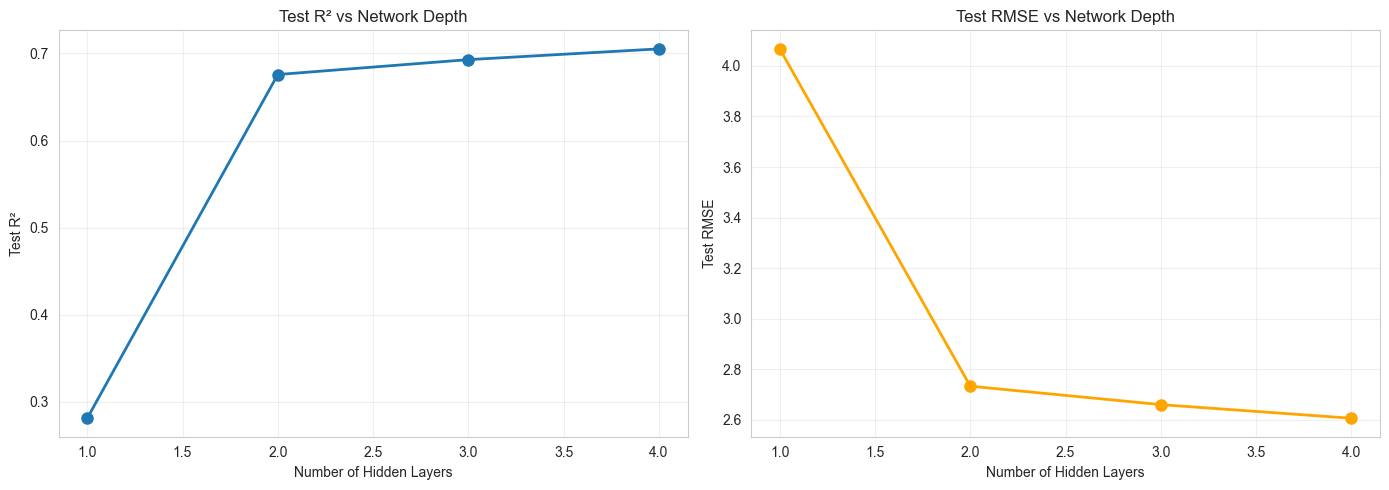


Layer Results:
 Layers  Test R²  Test RMSE
      1 0.281333   4.067565
      2 0.675701   2.732395
      3 0.692796   2.659405
      4 0.705126   2.605487


In [55]:
# Compare different numbers of layers (fixed width)
layer_counts = [1, 2, 3, 4]
layer_results = []

for num_layers in layer_counts:
    print(f"Training {num_layers} layer(s)...")
    
    model = mlp(
        hidden_units=tuple([50] * num_layers),
        activation='relu',
        epochs=200
    ).set_mode('regression')
    
    fitted = model.fit(train_mlp, 'y ~ .')
    
    test_pred = fitted.predict(test_mlp)
    test_r2 = r2_score(test_mlp['y'], test_pred['.pred'])
    test_rmse = np.sqrt(mean_squared_error(test_mlp['y'], test_pred['.pred']))
    
    layer_results.append({
        'Layers': num_layers,
        'Test R²': test_r2,
        'Test RMSE': test_rmse
    })

layer_df = pd.DataFrame(layer_results)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(layer_df['Layers'], layer_df['Test R²'], 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Hidden Layers')
axes[0].set_ylabel('Test R²')
axes[0].set_title('Test R² vs Network Depth')
axes[0].grid(alpha=0.3)

axes[1].plot(layer_df['Layers'], layer_df['Test RMSE'], 'o-', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Number of Hidden Layers')
axes[1].set_ylabel('Test RMSE')
axes[1].set_title('Test RMSE vs Network Depth')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nLayer Results:")
print(layer_df.to_string(index=False))

### Activation Functions

Different activation functions affect learning dynamics:

In [56]:
# Compare activation functions
activations = ['relu', 'tanh', 'logistic']
activation_results = []

for activation in activations:
    print(f"Training with {activation} activation...")
    
    model = mlp(
        hidden_units=50,
        activation=activation,
        epochs=200
    ).set_mode('regression')
    
    fitted = model.fit(train_mlp, 'y ~ .')
    
    # Predict
    train_pred = fitted.predict(train_mlp)
    test_pred = fitted.predict(test_mlp)
    
    # Metrics
    train_r2 = r2_score(train_mlp['y'], train_pred['.pred'])
    test_r2 = r2_score(test_mlp['y'], test_pred['.pred'])
    test_rmse = np.sqrt(mean_squared_error(test_mlp['y'], test_pred['.pred']))
    
    activation_results.append({
        'Activation': activation,
        'Train R²': f'{train_r2:.3f}',
        'Test R²': f'{test_r2:.3f}',
        'Test RMSE': f'{test_rmse:.3f}'
    })

activation_df = pd.DataFrame(activation_results)
print("\nActivation Function Comparison:")
print(activation_df.to_string(index=False))

print("\nActivation Function Notes:")
print("- ReLU: Fast, avoids vanishing gradients, most common")
print("- Tanh: Centered around 0, good for normalized data")
print("- Logistic (Sigmoid): Bounded [0,1], can suffer from vanishing gradients")

Training with relu activation...
Training with tanh activation...
Training with logistic activation...

Activation Function Comparison:
Activation Train R² Test R² Test RMSE
      relu    0.413   0.281     4.068
      tanh    0.245   0.162     4.393
  logistic   -0.094  -0.029     4.866

Activation Function Notes:
- ReLU: Fast, avoids vanishing gradients, most common
- Tanh: Centered around 0, good for normalized data
- Logistic (Sigmoid): Bounded [0,1], can suffer from vanishing gradients


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### MLP Visualization on 1D Data

See how MLP captures non-linearity:

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


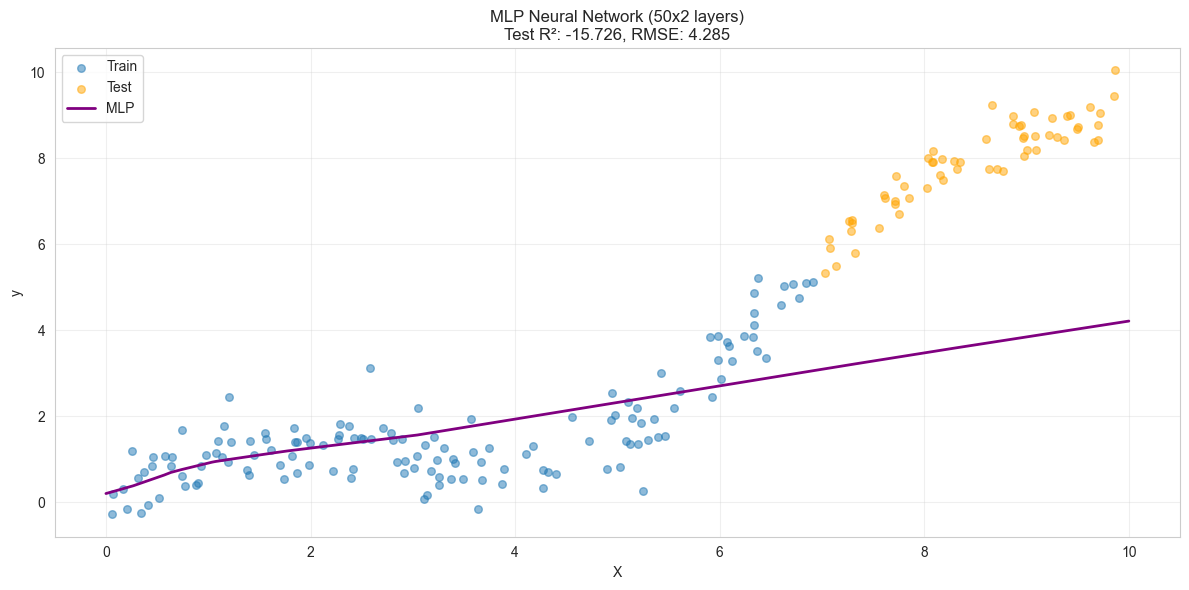


MLP successfully captures complex non-linear patterns.


In [57]:
# Generate complex 1D pattern
np.random.seed(42)
X_1d = np.sort(np.random.rand(200, 1) * 10, axis=0)
y_1d = np.sin(X_1d).ravel() + 0.1 * X_1d.ravel()**2 + np.random.randn(200) * 0.5

train_1d = pd.DataFrame({'X': X_1d[:140].ravel(), 'y': y_1d[:140]})
test_1d = pd.DataFrame({'X': X_1d[140:].ravel(), 'y': y_1d[140:]})

# Fit MLP
model_1d = mlp(
    hidden_units=50,
    activation='relu',
    epochs=300
).set_mode('regression')
fitted_1d = model_1d.fit(train_1d, 'y ~ X')

# Predict
X_plot = np.linspace(0, 10, 300).reshape(-1, 1)
plot_1d = pd.DataFrame({'X': X_plot.ravel()})
predictions_1d = fitted_1d.predict(plot_1d)
test_pred_1d = fitted_1d.predict(test_1d)

# Metrics
test_r2 = r2_score(test_1d['y'], test_pred_1d['.pred'])
test_rmse = np.sqrt(mean_squared_error(test_1d['y'], test_pred_1d['.pred']))

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(train_1d['X'], train_1d['y'], alpha=0.5, label='Train', s=30)
plt.scatter(test_1d['X'], test_1d['y'], alpha=0.5, label='Test', s=30, color='orange')
plt.plot(X_plot, predictions_1d['.pred'], 'purple', linewidth=2, label='MLP')
plt.xlabel('X')
plt.ylabel('y')
plt.title(f'MLP Neural Network (50x2 layers)\nTest R²: {test_r2:.3f}, RMSE: {test_rmse:.3f}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nMLP successfully captures complex non-linear patterns.")

## 6. Model Comparison

Let's compare all five models on the same dataset to understand their strengths and weaknesses.

In [58]:
# Create comprehensive comparison dataset
X_compare, y_compare = make_friedman1(n_samples=400, n_features=10, noise=1.0, random_state=42)
df_compare = pd.DataFrame(X_compare, columns=[f'X{i+1}' for i in range(10)])
df_compare['y'] = y_compare

train_compare, test_compare = train_test_split(df_compare, test_size=0.3, random_state=42)

print(f"Comparison dataset: {len(train_compare)} train, {len(test_compare)} test")
print(f"Features: {X_compare.shape[1]}")
print(f"Target range: [{y_compare.min():.1f}, {y_compare.max():.1f}]")

Comparison dataset: 280 train, 120 test
Features: 10
Target range: [3.2, 28.5]


### Performance Table

Train and evaluate all five models:

In [59]:
import time

# Define all models
all_models = {
    'Decision Tree': decision_tree(tree_depth=8, min_n=10).set_mode('regression'),
    'k-NN': nearest_neighbor(neighbors=5, weight_func='distance').set_mode('regression'),
    'SVM-RBF': svm_rbf(cost=10.0, rbf_sigma=0.1).set_mode('regression'),
    'SVM-Linear': svm_linear(cost=1.0).set_mode('regression'),
    'MLP': mlp(hidden_units=50, activation='relu', epochs=200).set_mode('regression')
}

comparison_results = []

for name, model in all_models.items():
    print(f"Training {name}...")
    
    # Time training
    start = time.time()
    fitted = model.fit(train_compare, 'y ~ .')
    fit_time = time.time() - start
    
    # Predict
    train_pred = fitted.predict(train_compare)
    test_pred = fitted.predict(test_compare)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(train_compare['y'], train_pred['.pred']))
    test_rmse = np.sqrt(mean_squared_error(test_compare['y'], test_pred['.pred']))
    train_r2 = r2_score(train_compare['y'], train_pred['.pred'])
    test_r2 = r2_score(test_compare['y'], test_pred['.pred'])
    
    comparison_results.append({
        'Model': name,
        'Fit Time (s)': f'{fit_time:.3f}',
        'Train RMSE': f'{train_rmse:.2f}',
        'Test RMSE': f'{test_rmse:.2f}',
        'Train R²': f'{train_r2:.3f}',
        'Test R²': f'{test_r2:.3f}',
        'Overfit Gap': f'{train_r2 - test_r2:.3f}'
    })

comparison_df = pd.DataFrame(comparison_results)
print("\n" + "="*80)
print("MODEL COMPARISON - ALL 5 ALGORITHMS")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

Training Decision Tree...
Training k-NN...
Training SVM-RBF...
Training SVM-Linear...
Training MLP...

MODEL COMPARISON - ALL 5 ALGORITHMS
        Model Fit Time (s) Train RMSE Test RMSE Train R² Test R² Overfit Gap
Decision Tree        0.013       1.38      3.29    0.931   0.473       0.458
         k-NN        0.008       0.00      3.05    1.000   0.546       0.454
      SVM-RBF        0.009       2.45      2.53    0.781   0.686       0.095
   SVM-Linear        0.005       2.68      2.67    0.736   0.651       0.086
          MLP        0.070       4.08      3.85    0.391   0.274       0.116


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Visual Comparison

Plot model performance side-by-side:

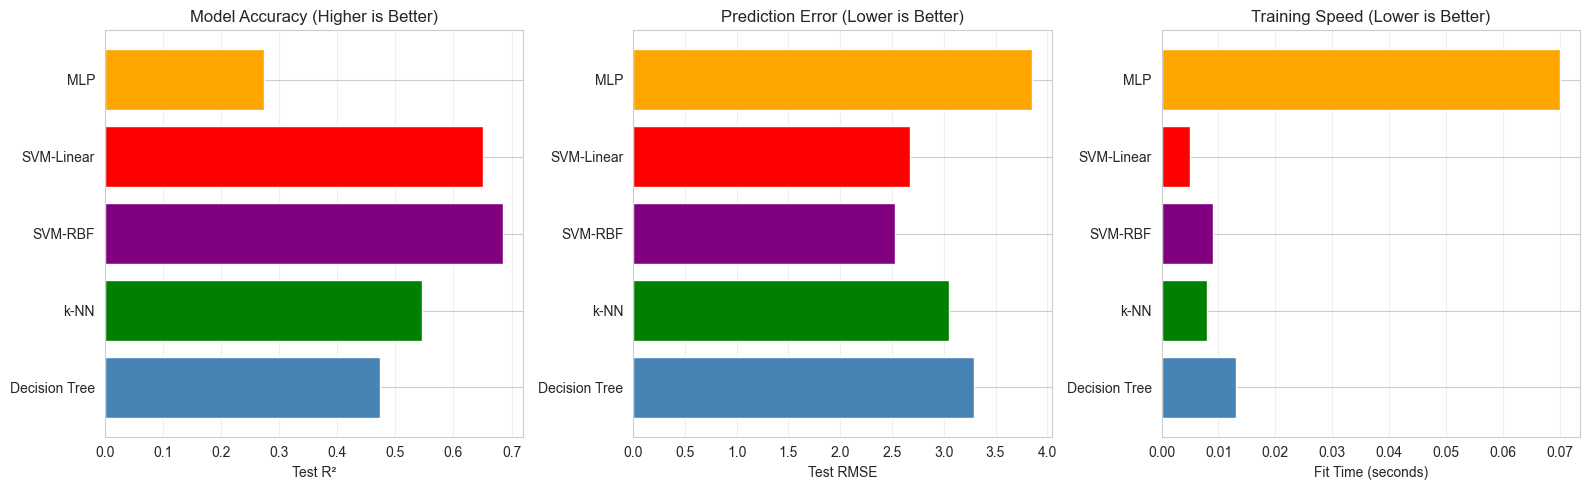

In [60]:
# Extract numeric values for plotting
models_list = comparison_df['Model'].values
test_r2_values = [float(x) for x in comparison_df['Test R²'].values]
test_rmse_values = [float(x) for x in comparison_df['Test RMSE'].values]
fit_times = [float(x) for x in comparison_df['Fit Time (s)'].values]

# Create comparison plots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# R² comparison
colors = ['steelblue', 'green', 'purple', 'red', 'orange']
axes[0].barh(models_list, test_r2_values, color=colors)
axes[0].set_xlabel('Test R²')
axes[0].set_title('Model Accuracy (Higher is Better)')
axes[0].grid(alpha=0.3, axis='x')

# RMSE comparison
axes[1].barh(models_list, test_rmse_values, color=colors)
axes[1].set_xlabel('Test RMSE')
axes[1].set_title('Prediction Error (Lower is Better)')
axes[1].grid(alpha=0.3, axis='x')

# Training time comparison
axes[2].barh(models_list, fit_times, color=colors)
axes[2].set_xlabel('Fit Time (seconds)')
axes[2].set_title('Training Speed (Lower is Better)')
axes[2].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### When to Use Each Model

Here's a practical guide for choosing between these models:

#### Decision Tree
**Best for:**
- Interpretability is critical
- Mixed feature types (numeric + categorical)
- Quick baseline model
- Feature importance analysis

**Avoid when:**
- Need smooth predictions
- Data is high-dimensional
- Small dataset (prone to overfitting)

#### k-Nearest Neighbors
**Best for:**
- Non-parametric problems
- Local patterns matter
- Online learning (easy to update)
- Small to medium datasets

**Avoid when:**
- High-dimensional data (curse of dimensionality)
- Need fast predictions (slow at inference)
- Sparse data

#### SVM-RBF
**Best for:**
- Complex non-linear patterns
- Medium-sized datasets
- Need good generalization
- Well-defined feature space

**Avoid when:**
- Very large datasets (slow training)
- Need interpretability
- Relationship is mostly linear

#### SVM-Linear
**Best for:**
- High-dimensional data
- Linear/near-linear relationships
- Large datasets
- Need fast training

**Avoid when:**
- Highly non-linear patterns
- Small number of features
- Need feature importance

#### Multi-layer Perceptron (MLP)
**Best for:**
- Complex non-linear patterns
- Large datasets
- High-dimensional inputs
- When you can tune hyperparameters

**Avoid when:**
- Small datasets (overfitting)
- Need interpretability
- Limited computational resources
- Quick prototyping needed

In [61]:
# Create a recommendation matrix
recommendation_data = {
    'Scenario': [
        'Small dataset (<100 samples)',
        'Large dataset (>10,000 samples)',
        'High dimensional (>50 features)',
        'Need interpretability',
        'Complex non-linearity',
        'Mostly linear relationship',
        'Fast training required',
        'Fast prediction required',
        'Feature importance needed'
    ],
    'Best Choice': [
        'k-NN or Decision Tree',
        'SVM-Linear or MLP',
        'SVM-Linear or MLP',
        'Decision Tree',
        'SVM-RBF or MLP',
        'SVM-Linear',
        'Decision Tree or SVM-Linear',
        'Decision Tree or SVM-Linear',
        'Decision Tree'
    ],
    'Avoid': [
        'MLP (overfitting)',
        'k-NN (memory)',
        'k-NN (curse of dimensionality)',
        'MLP or SVM',
        'SVM-Linear',
        'k-NN (inefficient)',
        'SVM-RBF or MLP',
        'k-NN (slow)',
        'k-NN or SVM'
    ]
}

recommendation_df = pd.DataFrame(recommendation_data)
print("\nMODEL SELECTION GUIDE")
print("="*80)
print(recommendation_df.to_string(index=False))
print("="*80)


MODEL SELECTION GUIDE
                       Scenario                 Best Choice                          Avoid
   Small dataset (<100 samples)       k-NN or Decision Tree              MLP (overfitting)
Large dataset (>10,000 samples)           SVM-Linear or MLP                  k-NN (memory)
High dimensional (>50 features)           SVM-Linear or MLP k-NN (curse of dimensionality)
          Need interpretability               Decision Tree                     MLP or SVM
          Complex non-linearity              SVM-RBF or MLP                     SVM-Linear
     Mostly linear relationship                  SVM-Linear             k-NN (inefficient)
         Fast training required Decision Tree or SVM-Linear                 SVM-RBF or MLP
       Fast prediction required Decision Tree or SVM-Linear                    k-NN (slow)
      Feature importance needed               Decision Tree                    k-NN or SVM


## 7. Understanding the Three-DataFrame Structure

All py-tidymodels models follow a consistent output structure. Let's examine the three DataFrames returned by each operation.

In [62]:
# Create sample data
sample_data = pd.DataFrame({
    'feature_1': [1.0, 2.0, 3.0, 4.0, 5.0],
    'feature_2': [2.5, 3.5, 4.5, 5.5, 6.5],
    'target': [10.0, 20.0, 30.0, 40.0, 50.0]
})

new_data = pd.DataFrame({
    'feature_1': [2.5, 3.5],
    'feature_2': [3.0, 4.0]
})

print("Sample training data:")
print(sample_data)
print("\nNew data for prediction:")
print(new_data)

Sample training data:
   feature_1  feature_2  target
0        1.0        2.5    10.0
1        2.0        3.5    20.0
2        3.0        4.5    30.0
3        4.0        5.5    40.0
4        5.0        6.5    50.0

New data for prediction:
   feature_1  feature_2
0        2.5        3.0
1        3.5        4.0


### DataFrame 1: Model Specification

The specification object contains model configuration:

In [63]:
# Create model specification
model_spec = decision_tree(tree_depth=5, min_n=2).set_mode('regression')

print("Model Specification Object:")
print(f"Type: {type(model_spec)}")
print(f"\nModel type: {model_spec.model_type}")
print(f"Mode: {model_spec.mode}")
print(f"Engine: {model_spec.engine}")
print(f"\nParameters:")
for param, value in model_spec.args.items():
    print(f"  {param}: {value}")

print("\nKey insight: Specification is reusable and doesn't contain any fitted data.")

Model Specification Object:
Type: <class 'py_parsnip.model_spec.ModelSpec'>

Model type: decision_tree
Mode: regression
Engine: sklearn

Parameters:
  tree_depth: 5
  min_n: 2

Key insight: Specification is reusable and doesn't contain any fitted data.


### DataFrame 2: Fitted Model

The fitted object contains the trained model and metadata:

In [64]:
# Fit the model
fitted_model = model_spec.fit(sample_data, 'target ~ .')

print("Fitted Model Object:")
print(f"Type: {type(fitted_model)}")
print(f"\nUnderlying sklearn model: {type(fitted_model.fit_data['model'])}")
print(f"Model is fitted: {hasattr(fitted_model.fit_data['model'], 'tree_')}")

# Access the underlying sklearn model
print("\nDirect access to sklearn model attributes:")
print(f"Tree depth: {fitted_model.fit_data['model'].get_depth()}")
print(f"Number of leaves: {fitted_model.fit_data['model'].get_n_leaves()}")

print("\nKey insight: Fitted object wraps sklearn model with tidymodels interface.")

Fitted Model Object:
Type: <class 'py_parsnip.model_spec.ModelFit'>

Underlying sklearn model: <class 'sklearn.tree._classes.DecisionTreeRegressor'>
Model is fitted: True

Direct access to sklearn model attributes:
Tree depth: 3
Number of leaves: 5

Key insight: Fitted object wraps sklearn model with tidymodels interface.


### DataFrame 3: Predictions

The predictions object is a clean DataFrame with results:

In [65]:
# Make predictions
predictions = fitted_model.predict(new_data)

print("Predictions Object:")
print(f"Type: {type(predictions)}")
print(f"Shape: {predictions.shape}")
print(f"\nColumns: {predictions.columns.tolist()}")
print("\nPredictions DataFrame:")
print(predictions)

# Predictions can be easily manipulated
predictions['rounded'] = predictions['.pred'].round(1)
print("\nWith added column:")
print(predictions)

print("\nKey insight: Predictions are standard pandas DataFrames for easy manipulation.")

Predictions Object:
Type: <class 'pandas.core.frame.DataFrame'>
Shape: (2, 1)

Columns: ['.pred']

Predictions DataFrame:
   .pred
0   10.0
1   30.0

With added column:
   .pred  rounded
0   10.0     10.0
1   30.0     30.0

Key insight: Predictions are standard pandas DataFrames for easy manipulation.


### Complete Workflow Example

Let's see the full three-step workflow with each model:

In [66]:
# Prepare data
workflow_data = pd.DataFrame({
    'X1': np.random.rand(50),
    'X2': np.random.rand(50),
    'X3': np.random.rand(50),
    'y': np.random.rand(50) * 100
})

test_data = workflow_data.iloc[:5].drop('y', axis=1)

models_to_demo = {
    'Decision Tree': decision_tree(tree_depth=5).set_mode('regression'),
    'k-NN': nearest_neighbor(neighbors=5).set_mode('regression'),
    'SVM-Linear': svm_linear(cost=1.0).set_mode('regression')
}

print("THREE-STEP WORKFLOW FOR EACH MODEL")
print("="*80)

for name, model_spec in models_to_demo.items():
    print(f"\n{name}:")
    print("-" * 40)
    
    # Step 1: Specify
    print("Step 1 - Specification:")
    print(f"  Created: {type(model_spec).__name__}")
    
    # Step 2: Fit
    fitted = model_spec.fit(workflow_data, 'y ~ .')
    print("Step 2 - Fitted Model:")
    print(f"  Type: {type(fitted).__name__}")
    
    # Step 3: Predict
    preds = fitted.predict(test_data)
    print("Step 3 - Predictions:")
    print(f"  Shape: {preds.shape}")
    print(f"  Columns: {preds.columns.tolist()}")
    print(f"  Sample values: {preds['.pred'].iloc[:3].values}")

print("\n" + "="*80)
print("All models follow the same consistent interface!")

THREE-STEP WORKFLOW FOR EACH MODEL

Decision Tree:
----------------------------------------
Step 1 - Specification:
  Created: ModelSpec
Step 2 - Fitted Model:
  Type: ModelFit
Step 3 - Predictions:
  Shape: (5, 1)
  Columns: ['.pred']
  Sample values: [23.04002623 66.92714486 44.28216021]

k-NN:
----------------------------------------
Step 1 - Specification:
  Created: ModelSpec
Step 2 - Fitted Model:
  Type: ModelFit
Step 3 - Predictions:
  Shape: (5, 1)
  Columns: ['.pred']
  Sample values: [43.56881874 57.72243381 36.76988418]

SVM-Linear:
----------------------------------------
Step 1 - Specification:
  Created: ModelSpec
Step 2 - Fitted Model:
  Type: ModelFit
Step 3 - Predictions:
  Shape: (5, 1)
  Columns: ['.pred']
  Sample values: [30.17983311 24.99135325 29.40663387]

All models follow the same consistent interface!


## Summary

This notebook demonstrated the five sklearn regression models available in py-tidymodels:

1. **Decision Tree**: Interpretable, captures non-linearity, but prone to overfitting
2. **k-NN**: Non-parametric, good for local patterns, but slow in high dimensions
3. **SVM-RBF**: Excellent for complex non-linear relationships, moderate training time
4. **SVM-Linear**: Fast and efficient for high-dimensional linear problems
5. **MLP**: Powerful for complex patterns, requires more data and tuning

### Key Takeaways:

- **Consistent Interface**: All models follow specify → fit → predict
- **Three-Step Workflow**: Specification, fitted model, predictions
- **Model Selection**: Choose based on data characteristics and requirements
- **Hyperparameter Tuning**: Critical for optimal performance
- **Bias-Variance Tradeoff**: Balance model complexity with generalization

### Next Steps:

- Explore ensemble methods (Random Forest, Gradient Boosting)
- Implement cross-validation for hyperparameter tuning
- Try preprocessing and feature engineering
- Combine models in workflows for production pipelines